# One Way to Measure Algorithmic Fairness
> as described in the scikit-lego documentation
- toc: false,
- badges: true,
- comments: true,
- categories: [machine learning, algorithmic bias, python],
- image: images/algorithmic_fairness.JPG,
- search_exclude: false,
- permalink: /algorithmic-fairness

> Tip: The code required to build a pipeline designed to optimize a machine learning model 

In [1]:
#collapse-hide
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt

from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklego.preprocessing import InformationFilter

import warnings
warnings.filterwarnings('ignore')

## tl:dr

Scikit-Learn comes with a copy of UC Irvine's ML housing dataset, which was taken from the StatLib library which is maintained at Carnegie Mellon University. This dataset contains features like "lower status of population" and "the proportion of blacks by town". This is bad. There's a real possibility that any model made from this dataset will overfit on MSE and underfit on fairness when we want to apply it. Scikit-Lego has some support to deal with fairness issues like this one.

## Measuring Fairness 

Scikit learn comes with the boston housing dataset. We can make a simple pipeline with it and make us a small model. We can even write the code to also make a plot that can convince us that we're doing well.

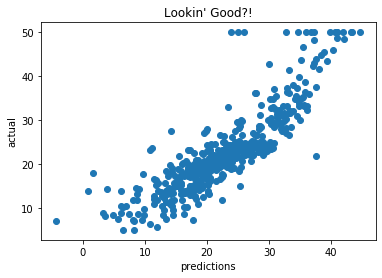

In [21]:
#collapse-hide
X, y = load_boston(return_X_y=True)

pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", LinearRegression())
])

plt.scatter(pipe.fit(X, y).predict(X), y)
plt.xlabel("predictions")
plt.ylabel("actual")
plt.title("Lookin' Good?!");

We could stop our research here if we think that our MSE is "good enough" but this would be dangerous. To find out why, we should look at the variables that are being used in our model. 

In [22]:
#collapse-hide
print(load_boston()['DESCR'][:1200])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

This dataset contains features like "lower status of population" and "the proportion of blacks by town". This is bad. There's a real possibility that our model will overfit on MSE and underfit on fairness when we want to apply it. Scikit-Lego has some support to deal with fairness issues like this one. 

Dealing with issues such as fairness in machine learning can in general be done in three ways: 

- Data preprocessing
- Model contraints
- Prediction postprocessing.

But before we can dive into methods for getting more fair predictions, we first need to define how to measure fairness


###  Of Regression

Measuring fairness can be done in many ways but we'll consider one definition: the output of the model is fair with regards to groups $A$ and $B$ if prediction has a distribution independant if group $A$ or $B$. In laymans terms: if group $A$ and $B$ don't get the same predictions: no bueno. 

Formally, this can be written as:

$$fairness = \left\lvert \frac{1}{|Z_1|} \sum_{i \in Z_1} \hat{y}_{i} - \frac{1}{|Z_0|} \sum_{i \in Z_0} \hat{y}_{i} \right\rvert$$

where $Z_1$ is the subset of the population where our sensitive attribute is true, and $Z_0$ the subset of the population where the sensitive attribute is false

To estimate this we'll use bootstrap sampling to measure the models bias.

###  Of Classification

A common method for measuring fairness is __demographic parity__[<sup>1</sup>](#fn1), for example through the p-percent metric. 
The idea behind it is that it requires that a decision — such as accepting or denying a loan application — be independent of the protected attribute. In other words, we expect the __positive__ rate in both groups to be the same. In the case of a binary decision $\hat{y}$ and a binary protected attribute $z$, this constraint can be formalized by asking that

$$P(\hat{y}=1 | z=0)=P(\hat{y}=1 | z=1)$$

You can turn this into a metric by calculating how far off this exact equality your decision process is. This metric is called the p% score

$$\text{p% score} = \min \left(\frac{P(\hat{y}=1 | z=1)}{P(\hat{y}=1 | z=0)}, \frac{P(\hat{y}=1 | z=0)}{P(\hat{y}=1 | z=1)}\right)$$

In other words, membership in a protected class should have no correlation with the decision.

In `sklego` this metric is implemented in `sklego.metrics.p_percent_score` and it works as follows:


In [23]:
#collapse-hide
from sklego.metrics import p_percent_score
from sklearn.linear_model import LogisticRegression

sensitive_classification_dataset = pd.DataFrame({
    "x1": [1, 0, 1, 0, 1, 0, 1, 1],
    "x2": [0, 0, 0, 0, 0, 1, 1, 1],
    "y": [1, 1, 1, 0, 1, 0, 0, 0]}
)

X, y = sensitive_classification_dataset.drop(columns='y'), sensitive_classification_dataset['y']
mod_unfair = LogisticRegression(solver='lbfgs').fit(X, y)

print('p_percent_score:', p_percent_score(sensitive_column="x2")(mod_unfair, X))

p_percent_score: 0


Of course, no metric is perfect. If we for example use this in a loan approval situation, the demographic parity only looks at loans given, and not at the rate at which loans are paid back. That might result in a lower percentage of qualified people who are given loans in one population than in another. Another way of measuring fairness could be therefore to measure __equal opportunity__[<sup>2</sup>](#fn2) instead. This constraint would boil down to:

$$P(\hat{y}=1 | z=0, y=1)=P(\hat{y}=1 | z=1, y=1)$$

and be turned into a metric in the same way as above:

$$\text{equality of opportunity} = \min \left(\frac{P(\hat{y}=1 | z=1, y=1)}{P(\hat{y}=1 | z=0, y=1)}, \frac{P(\hat{y}=1 | z=0, y=1)}{P(\hat{y}=1 | z=1, y=1)}\right)$$

We can see in the example below that the equal opportunity score does not differ for the models as long as the records where `y_true = 1` are predicted correctly.

In [24]:
#collapse-hide
from sklego.metrics import equal_opportunity_score
from sklearn.linear_model import LogisticRegression
import types

sensitive_classification_dataset = pd.DataFrame({
    "x1": [1, 0, 1, 0, 1, 0, 1, 1],
    "x2": [0, 0, 0, 0, 0, 1, 1, 1],
    "y": [1, 1, 1, 0, 1, 0, 0, 1]}
)

X, y = sensitive_classification_dataset.drop(columns='y'), sensitive_classification_dataset['y']

mod_1 = types.SimpleNamespace()

mod_1.predict = lambda X: np.array([1, 0, 1, 0, 1, 0, 1, 1])
print('equal_opportunity_score:', equal_opportunity_score(sensitive_column="x2")(mod_1, X, y))

mod_1.predict = lambda X: np.array([1, 0, 1, 0, 1, 0, 0, 1])
print('equal_opportunity_score:', equal_opportunity_score(sensitive_column="x2")(mod_1, X, y))

mod_1.predict = lambda X: np.array([1, 0, 1, 0, 1, 0, 0, 0])

print('equal_opportunity_score:', equal_opportunity_score(sensitive_column="x2")(mod_1, X, y))

equal_opportunity_score: 0.75
equal_opportunity_score: 0.75
equal_opportunity_score: 0.0


## Data preprocessing
When doing data preprocessing we're trying to remove any bias caused by the sensitive variable from the input dataset. By doing this, we remain flexible in our choice of models.

### Information Filter

This is a great opportunity to use the `InformationFilter` which can filter the information of these two sensitive columns away as a transformation step. It does this by projecting all vectors away such that the remaining dataset is orthogonal to the sensitive columns.

#### How it Works 

The `InformationFilter` uses a variant of the [gram smidt process](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process) to filter information out of the dataset. We can make it visual in two dimensions;

![](../images/projections.png)

To explain what occurs in higher dimensions we need to resort to maths. Take a training matrix $X$ that contains columns $x_1, ..., x_k$. If we assume columns $x_1$ and $x_2$ to be the sensitive columns then the information filter will filter out information using this approach; 

$$
\begin{split}
v_1 & = x_1 \\
v_2 & = x_2 - \frac{x_2 v_1}{v_1 v_1}\\
v_3 & = x_3 - \frac{x_3 v_1}{v_1 v_1} - \frac{x_3 v_2}{v_2 v_2}\\
... \\ 
v_k & = x_k - \frac{x_k v_1}{v_1 v_1} - \frac{x_k' v_2}{v_2 v_2}
\end{split}
$$

Concatenating our vectors (but removing the sensitive ones) gives us a new training matrix $X_{\text{more fair}} =  [v_3, ..., v_k]$. 

## Experiment 

We will demonstrate the effect of applying this by benchmarking three things: 

1. Keep $X$ as is. 
2. Drop the two columns that are sensitive.
3. Use the information filter

We'll use the regression metric defined above to show the differences in fairness

In [25]:
#collapse-hide
X, y = load_boston(return_X_y=True)
df = pd.DataFrame(X, columns=['crim','zn','indus','chas','nox',
                              'rm','age','dis','rad','tax','ptratio',
                              'b','lstat'])
X_drop = df.drop(columns=["lstat", "b"])
X_fair = InformationFilter(["lstat", "b"]).fit_transform(df)
X_fair = pd.DataFrame(X_fair, 
                      columns=[n for n in df.columns if n not in ['b', 'lstat']])

In [26]:
#collapse-hide
def simple_mod():
    return Pipeline([("scale", StandardScaler()), ("mod", LinearRegression())])

base_mod = simple_mod().fit(X, y)
drop_mod = simple_mod().fit(X_drop, y)
fair_mod = simple_mod().fit(X_fair, y)

base_pred = base_mod.predict(X)
drop_pred = drop_mod.predict(X_drop)
fair_pred = fair_mod.predict(X_fair)

We can see that the coefficients of the three models are indeed different.

In [27]:
#collapse-hide
pd.DataFrame([base_mod.steps[1][1].coef_, drop_mod.steps[1][1].coef_, fair_mod.steps[1][1].coef_], columns=df.columns)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
0,-0.928146,1.081569,0.140900,0.681740,-2.056718,2.674230,0.019466,-3.104044,2.662218,-2.076782,-2.060607,0.849268,-3.743627
1,-1.581396,0.911004,-0.290074,0.884936,-2.567870,4.264702,-1.270735,-3.331836,2.215737,-2.056246,-2.154600,NaN,NaN
2,-0.763568,1.028051,0.061393,0.697504,-1.605464,6.846774,-0.057920,-2.537602,1.935058,-1.779825,-2.793069,NaN,NaN


In [28]:
#collapse-hide
# we're using lstat to select the group to keep things simple
selector = df["lstat"] > np.quantile(df["lstat"], 0.5)

def bootstrap_means(preds, selector, n=2500, k=25):
    grp1 = np.random.choice(preds[selector], (n, k)).mean(axis=1)
    grp2 = np.random.choice(preds[~selector], (n, k)).mean(axis=1)
    return grp1 - grp2

### Measuring Fairness of Original Scenario

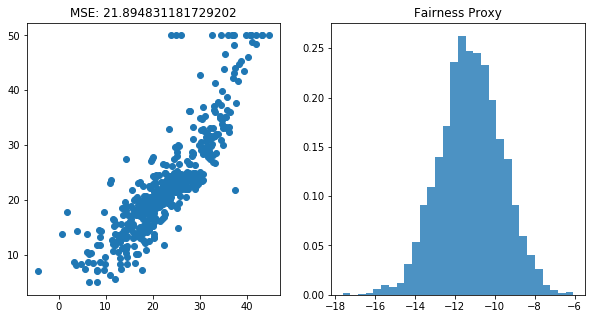

In [29]:
#collapse-hide
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(base_pred, y)
plt.title(f"MSE: {mean_squared_error(y, base_pred)}")
plt.subplot(122)
plt.hist(bootstrap_means(base_pred, selector), bins=30, density=True, alpha=0.8)
plt.title(f"Fairness Proxy");

### Measuring Fairness after Dropping Columns

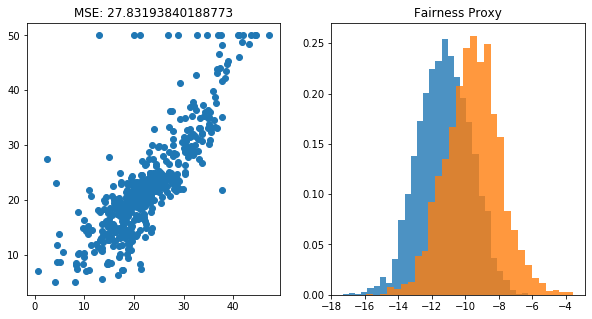

In [30]:
#collapse-hide
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(drop_pred, y)
plt.title(f"MSE: {mean_squared_error(y, drop_pred)}")
plt.subplot(122)
plt.hist(bootstrap_means(base_pred, selector), bins=30, density=True, alpha=0.8)
plt.hist(bootstrap_means(drop_pred, selector), bins=30, density=True, alpha=0.8)
plt.title(f"Fairness Proxy");

### Measuring Fairness after Applying Information Filter

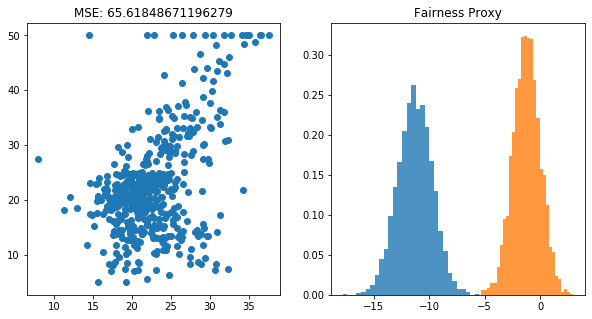

In [31]:
#collapse-hide
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(fair_pred, y)
plt.title(f"MSE: {mean_squared_error(y, fair_pred)}")
plt.subplot(122)
plt.hist(bootstrap_means(base_pred, selector), bins=30, density=True, alpha=0.8)
plt.hist(bootstrap_means(fair_pred, selector), bins=30, density=True, alpha=0.8)
plt.title(f"Fairness Proxy");

There definitely is a balance between fairness and model accuracy. Which model you'll use depends on the world you want to create by applying your model. 

Note that you can combine models here to make an ensemble too. You can also use the difference between the 1st and  last model as a proxy for bias.

## Model constraints

Another way we could tackle this fairness problem would be to explicitly take fairness into account when optimizing the parameters of our model. This is implemented in the `DemographicParityClassifier` as well as the `EqualOpportunityClassifier`.

Both these models are built as an extension of basic logistic regression. Where logistic regression optimizes the following problem:

$$\begin{array}{cl}
{\operatorname{minimize}} & -\sum_{i=1}^{N} \log p\left(y_{i} | \mathbf{x}_{i},\boldsymbol{\theta}\right)
\end{array}
$$

We would like to instead optimize this:

$$\begin{array}{cl}{\operatorname{minimize}} & -\sum_{i=1}^{N} \log p\left(y_{i} | \mathbf{x}_{i},
        \boldsymbol{\theta}\right)\\
{\text { subject to }} & \text{fairness} \geq \mathbf{c}\end{array}    $$  
        


## Demographic Parity Classifier

The p% score discussed above is a nice metric but unfortunately it is rather hard to directly implement in the formulation into our model as it is a non-convex function making it difficult to optimize directly. Also, as the p% rule only depends on which side of the decision boundary an observation lies, it is invariant in small changes in the decision boundary. This causes large saddle points in the objective making optimization even more difficult

Instead of optimizing for the p% directly, we approximate it by taking the covariance between the users’ sensitive
attributes, $z$m, and the decision boundary. This results in the following formulation of our `DemographicParityClassifier`.

$$\begin{array}{cl}{\operatorname{minimize}} & -\sum_{i=1}^{N} \log p\left(y_{i} | \mathbf{x}_{i},
        \boldsymbol{\theta}\right)\\
{\text { subject to }} & {\frac{1}{N} \sum_{i=1}^{N}\left(\mathbf{z}_{i}-\overline{\mathbf{z}}\right) d_
        \boldsymbol{\theta}\left(\mathbf{x}_{i}\right) \leq \mathbf{c}} \\
        {} & {\frac{1}{N} \sum_{i=1}^{N}\left(\mathbf{z}_{i}-\overline{\mathbf{z}}\right)
        d_{\boldsymbol{\theta}}\left(\mathbf{x}_{i}\right) \geq-\mathbf{c}}\end{array}    $$  
        
Let's see what the effect of this is. As this is a Classifier and not a Regressor, we transform the target to a binary variable indicating whether it is above or below the median. Our p% metric also assumes a binary indicator for sensitive columns so we do the same for our `lstat` column. 

Fitting the model is as easy as fitting a normal sklearn model. We just need to supply the columns that should be treated as sensitive to the model, as well as the maximum covariance we want to have. 

In [32]:
#collapse-hide
from sklego.linear_model import DemographicParityClassifier
from sklearn.linear_model import LogisticRegression
from sklego.metrics import p_percent_score

from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

df_clf = df.assign(lstat=lambda d: d['lstat'] > np.median(d['lstat']))
y_clf = y > np.median(y)

normal_classifier = LogisticRegression(solver='lbfgs')
normal_classifier.fit(df_clf, y_clf)
fair_classifier = DemographicParityClassifier(sensitive_cols="lstat", covariance_threshold=0.5)
fair_classifier.fit(df_clf, y_clf);

Comparing the two models on their p% scores also shows that the fair classifier has a much higher fairness score at a slight cost in accuracy.

We'll compare these two models by doing a gridsearch on the effect of the `covariance_threshold`.

In [33]:
#collapse-hide
fair_classifier = GridSearchCV(estimator=DemographicParityClassifier(sensitive_cols="lstat", 
                                                        covariance_threshold=0.5),
                               param_grid={"estimator__covariance_threshold": 
                                           np.linspace(0.01, 1.00, 20)},
                               cv=5,
                               refit="accuracy_score",
                               return_train_score=True,
                               scoring={"p_percent_score": p_percent_score('lstat'),
                                        "accuracy_score": make_scorer(accuracy_score)})

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fair_classifier.fit(df_clf, y_clf);

    pltr = (pd.DataFrame(fair_classifier.cv_results_)
            .set_index("param_estimator__covariance_threshold"))

    p_score = p_percent_score('lstat')(normal_classifier, df_clf, y_clf)
    acc_score = accuracy_score(normal_classifier.predict(df_clf), y_clf)

The results of the grid search are shown below. Note that the logistic regression results are of the train set, not the test set. We can see that the increase in fairness comes at the cost of accuracy but this might literally be a fair tradeoff. 

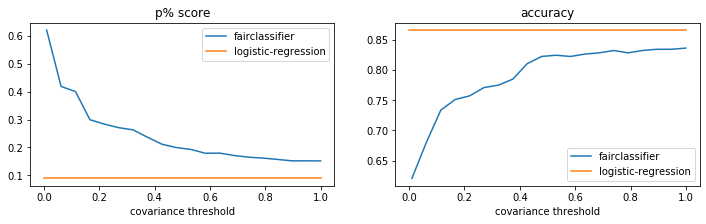

In [34]:
#collapse-hide
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(np.array(pltr.index), pltr['mean_test_p_percent_score'], label='fairclassifier')
plt.plot(np.linspace(0, 1, 2), [p_score for _ in range(2)], label='logistic-regression')
plt.xlabel("covariance threshold")
plt.legend()
plt.title("p% score")
plt.subplot(122)
plt.plot(np.array(pltr.index), pltr['mean_test_accuracy_score'], label='fairclassifier')
plt.plot(np.linspace(0, 1, 2), [acc_score for _ in range(2)], label='logistic-regression')
plt.xlabel("covariance threshold")
plt.legend()
plt.title("accuracy");

## Equal opportunity

In the same spirit as the `DemographicParityClassifier` discussed above, there is also an `EqualOpportunityClassifier` which optimizes

$$\begin{array}{cl}{\operatorname{minimize}} & -\sum_{i=1}^{N} \log p\left(y_{i} | \mathbf{x}_{i},
        \boldsymbol{\theta}\right) \\
        {\text { subject to }} & {\frac{1}{POS} \sum_{i=1}^{POS}\left(\mathbf{z}_{i}-\overline{\mathbf{z}}\right) d
        \boldsymbol{\theta}\left(\mathbf{x}_{i}\right) \leq \mathbf{c}} \\
        {} & {\frac{1}{POS} \sum_{i=1}^{POS}\left(\mathbf{z}_{i}-\overline{\mathbf{z}}\right)
        d_{\boldsymbol{\theta}}\left(\mathbf{x}_{i}\right) \geq-\mathbf{c}}\end{array}$$

where POS is the subset of the population where `y_true = positive_target`

In [35]:
#collapse-hide
from sklego.linear_model import EqualOpportunityClassifier

fair_classifier = GridSearchCV(
    estimator=EqualOpportunityClassifier(
        sensitive_cols="lstat", 
        covariance_threshold=0.5,
        positive_target=True,
    ),
    param_grid={"estimator__covariance_threshold": np.linspace(0.001, 1.00, 20)},
    cv=5,
    n_jobs=-1,
    refit="accuracy_score",
    return_train_score=True,
    scoring={"p_percent_score": p_percent_score('lstat'),
            "equal_opportunity_score": equal_opportunity_score('lstat'),
            "accuracy_score": make_scorer(accuracy_score)}
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fair_classifier.fit(df_clf, y_clf);

    pltr = (pd.DataFrame(fair_classifier.cv_results_)
            .set_index("param_estimator__covariance_threshold"))

    p_score = p_percent_score('lstat')(normal_classifier, df_clf, y_clf)
    acc_score = accuracy_score(normal_classifier.predict(df_clf), y_clf)

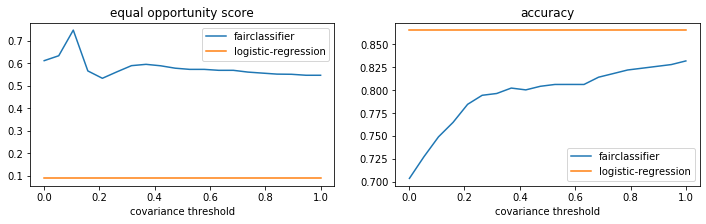

In [36]:
#collapse-hide
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.plot(np.array(pltr.index), pltr['mean_test_equal_opportunity_score'], label='fairclassifier')
plt.plot(np.linspace(0, 1, 2), [p_score for _ in range(2)], label='logistic-regression')
plt.xlabel("covariance threshold")
plt.legend()
plt.title("equal opportunity score")
plt.subplot(122)
plt.plot(np.array(pltr.index), pltr['mean_test_accuracy_score'], label='fairclassifier')
plt.plot(np.linspace(0, 1, 2), [acc_score for _ in range(2)], label='logistic-regression')
plt.xlabel("covariance threshold")
plt.legend()
plt.title("accuracy");

## Sources

<ol>
    <li id="fn1">M. Zafar et al. (2017), Fairness Constraints: Mechanisms for Fair Classification</li>
    <li id="fn2">M. Hardt, E. Price and N. Srebro (2016), Equality of Opportunity in Supervised Learning</li>
</ol>
    